In [3]:
# imports an stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots

In [4]:
# transformations for the training data with augmentation
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transformations = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# batch size and number of labels
batch_size = 64
num_labels = 12

# Directory with data
%cd ~/Desktop/ECE176/FinalProject/LandmarkClassifier-main
dataset_path = './data'

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path)

# split data
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = total_size - train_size
# split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# apply transformations
train_dataset.dataset.transform = train_transformations
val_dataset.dataset.transform = val_test_transformations

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# display sizes
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')


/Users/matteop/Desktop/ECE176/FinalProject/LandmarkClassifier-main
Number of training samples: 922
Number of validation samples: 396


In [5]:
# check if GPU is available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [6]:
# test the model on the validation set
def testVal(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(images)
            _, predicted = scores.max(1)
            num_correct += (predicted == labels).sum()
            num_samples += predicted.size(0)
    
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [7]:
# traiin model
def train(model, optimizer, num_epochs=1):
    model = model.to(device=device)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        # get training accuracy over epochs
        for i, (images, labels) in enumerate(train_loader):
            model.train()
            images = images.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)

            scores = model(images)
            loss_t = loss_fn(scores, labels)
            train_loss += loss_t.item()
            if i == len(train_loader) - 1:
                print('Epoch %d/%d, Training Loss = %.4f' % (epoch+1, num_epochs, loss_t.item()))

            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
        
        train_losses.append(train_loss / len(train_loader))

        # get validation accuracy over epochs
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)
                scores = model(images)
                loss_v = loss_fn(scores, labels)

                val_loss += loss_v.item()

        val_losses.append(val_loss / len(val_loader))
        

    return train_losses, val_losses

In [8]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = flatten(x)
        x = self.classifier(x)
        return x

In [9]:
# setup model and optimizer
loss_fn = nn.CrossEntropyLoss()

model = AlexNet(num_labels)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [10]:
# train model and get training and validation losses
train_loss, val_loss = train(model, optimizer, num_epochs=20)
print('Finished Training')

Epoch 1/20, Training Loss = 1.8515
Epoch 2/20, Training Loss = 1.6933
Epoch 3/20, Training Loss = 1.7375
Epoch 4/20, Training Loss = 1.6524
Epoch 5/20, Training Loss = 1.4340
Epoch 6/20, Training Loss = 1.0192
Epoch 7/20, Training Loss = 1.3262
Epoch 8/20, Training Loss = 0.8566
Epoch 9/20, Training Loss = 0.9871
Epoch 10/20, Training Loss = 0.5655
Epoch 11/20, Training Loss = 0.6383
Epoch 12/20, Training Loss = 0.5216
Epoch 13/20, Training Loss = 0.4568
Epoch 14/20, Training Loss = 0.5859
Epoch 15/20, Training Loss = 0.4416
Epoch 16/20, Training Loss = 0.4395
Epoch 17/20, Training Loss = 0.7827
Epoch 18/20, Training Loss = 0.5792
Epoch 19/20, Training Loss = 0.2836
Epoch 20/20, Training Loss = 0.1615
Finished Training


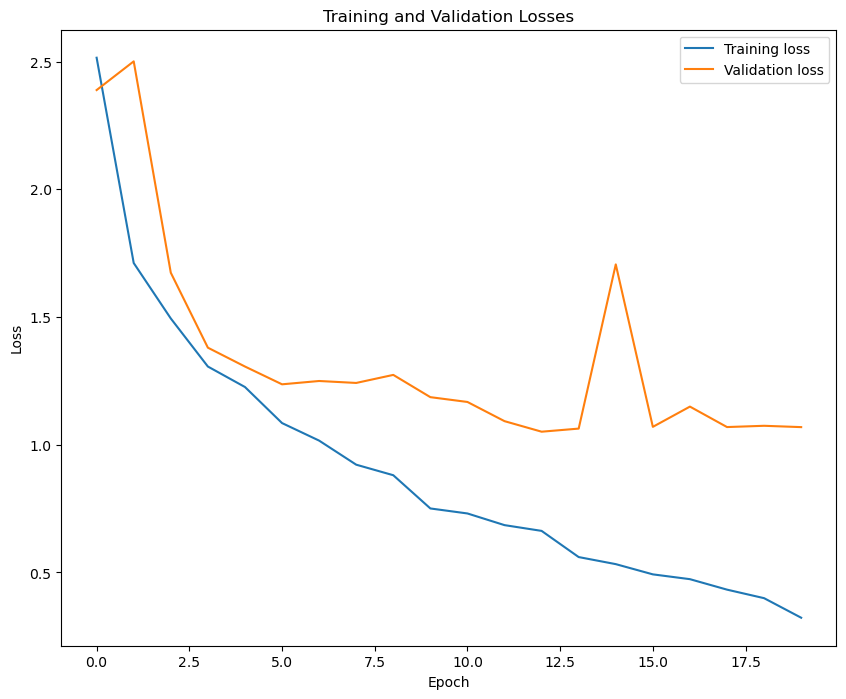

In [11]:
# plot the training and validation losses to check for overfitting
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
print('Validation Set Accuracy')
testVal(val_loader, model)

Validation Set Accuracy
Got 288 / 396 correct (72.73)
